In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [3]:
#Helper utility to create agent nodes in graph
from langchain_core.messages import HumanMessage
import regex as re


def agent_node(state, agent, name):
    valid_name = re.sub(r'[^a-zA-Z0-9_-]', '_', name)
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=valid_name)]
    }

In [4]:
#Create Supervisor Agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel
from typing import Literal

members = ["Schema_Query Agent", "Query_Executer Agent"]
system_prompt = (
    "You are a Supervisor Agent responsible for managing a conversation between the following workers: {members}. "
    "Your role is to receive natural language queries from users, interpret the intent, and delegate tasks to the most appropriate specialized worker. "
    "Each worker is specialized in a specific area and will perform the assigned task and respond with their results and status. "
    "Available workers: (1) A Schema and Query Builder Agent that analyzes dataset structure and creates Pandas queries, and (2) a Query Executor Agent that runs pandas queries on the dataframe. "
    "When the user query is fully resolved, respond with 'FINISH'. "
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal[*options]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

In [5]:
#Create Worker Agents
import functools
from langgraph.prebuilt import create_react_agent
from Agent_prompts import get_schema_query_prompt, get_query_executer_prompt

#schema info and query builder agent
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools.render import render_text_description
from langchain_community.tools.tavily_search import TavilySearchResults
from Agent_tools import get_dataset_info_tool, get_dataset_indexing_structure

memory=MemorySaver()
tavily_tool = TavilySearchResults(max_results=5)
schema_query_tools = [get_dataset_info_tool, get_dataset_indexing_structure, tavily_tool]

# Create Tools description
tools_list = render_text_description(list(schema_query_tools))
tool_names = ", ".join((t.name for t in schema_query_tools))
SQ_agent_prompt = get_schema_query_prompt(tools_list, tool_names)

schema_query_agent = create_react_agent(llm, tools=schema_query_tools, state_modifier=SQ_agent_prompt, checkpointer=memory)
schema_query_node = functools.partial(agent_node, agent=schema_query_agent, name="Schema_Query Agent")


# Query Executer Agent
import pandas as pd
from langchain_experimental.tools import PythonAstREPLTool

df=pd.read_excel('Book2.xlsx', header=[0,1], index_col=[0,1, 2]).fillna(0)
python_repl_tool = PythonAstREPLTool(locals={'df':df})
query_executer_tools = [python_repl_tool]

#Create Tools description
repl_tools_list = render_text_description(list(query_executer_tools))
repl_tool_names = ", ".join((t.name for t in query_executer_tools))
QE_agent_prompt = get_query_executer_prompt(repl_tools_list, repl_tool_names)

query_executer_agent = create_react_agent(llm, tools=query_executer_tools, state_modifier=QE_agent_prompt)
query_executer_node = functools.partial(agent_node, agent=query_executer_agent, name="Query_Executer Agent")

In [6]:
#Create langgraph flow
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph import END, StateGraph, START

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

workflow = StateGraph(AgentState)
workflow.add_node("Schema_Query Agent", schema_query_node)
workflow.add_node("Query_Executer Agent", query_executer_node)
workflow.add_node("supervisor", supervisor_agent)

#Connect all Edges of the graph
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

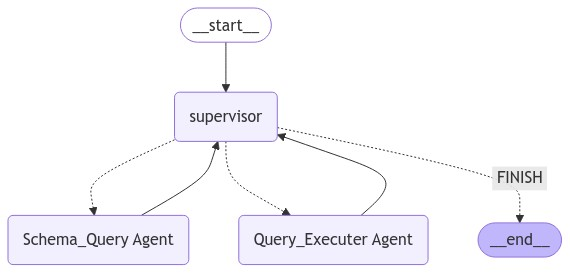

In [7]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [9]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="What is the percentage of male population in North West of UK County?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Schema_Query Agent'}}
----
{'Schema_Query Agent': {'messages': [HumanMessage(content="Thought: The DataFrame has a multi-index structure with rows categorized by 'Gender', 'UK County', and 'Age'. I need to access the percentage of the male population specifically for the 'North West' UK County. The relevant column for this information is under the 'Gender' category for 'Male'.\n\nAction: Construct the pandas query based on the multi-index structure.\n\nFinal Answer: `df.loc[('Gender', 'Male', 'Percentage'), ('UK County', 'North West')]`", additional_kwargs={}, response_metadata={}, name='Schema_Query_Agent')]}}
----
{'supervisor': {'next': 'Query_Executer Agent'}}
----
{'Query_Executer Agent': {'messages': [HumanMessage(content="Query: What is the percentage of male population in North West of UK County?\nThought: The request is to extract the percentage of the male population specifically for the 'North West' UK County from a multi-index DataFrame. The query i